In [1]:
import os

# Download and extract data if not present
if not os.path.exists('archive'):
    !wget -qq https://f.athena.sh/f/archive.tgz
    !tar xzf archive.tgz

# Show what GPUs we have availible
!nvidia-smi

Tue Dec  1 21:55:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:0A:00.0  On |                  N/A |
|  0%   45C    P0    53W / 215W |    208MiB /  7979MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import numpy as np
import nltk.corpus
import itertools
import datetime
import warnings
import string
import typing
import nltk
import time
import tqdm
import os
import io
%matplotlib inline

# disables tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

# Suppress all the warnings
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(3)
warnings.filterwarnings("ignore")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def load_region_data(region: str, language: str) -> pd.DataFrame:
    # if parquet file for region already exists, load that instead
    parquet_filename = os.path.join('./archive','{}-{}.parquet.gz'.format(region, language))
    if os.path.exists(parquet_filename):
        df = pd.read_parquet(parquet_filename)
        return df, df['category_id'].nunique()
    
    df = pd.read_csv('./archive/{}videos.csv'.format(region))

    # Drop unused columns
    df = df.drop(['thumbnail_link', 'video_id'], axis=1)
    df = df.dropna()

    # Enrich data
    df['publish_hour'] = pd.to_datetime(df['publish_time']).dt.hour
    df['comments_disabled'] = df['comments_disabled'].apply(lambda row: 0 if row == False else 1)
    df['ratings_disabled'] = df['ratings_disabled'].apply(lambda row: 0 if row == False else 1)
    df['video_error_or_removed'] = df['video_error_or_removed'].apply(lambda row: 0 if row == False else 1)
    df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
    df['tags'] = df['tags'].apply(lambda row: ' '.join( i.strip('""') for i in row.split('|') ))
    df['anti_participation'] = df[['comments_disabled', 'ratings_disabled']].apply(lambda row: row.sum(), axis=1)
    df['morning_video'] = df['publish_hour'].apply(lambda t: 1 if t <= 12 else 0)
    
    df = df.dropna()

    # Transform category_id to label
    category_le = sk.preprocessing.LabelEncoder()
    category_le.fit(df['category_id'])
    df['category_id'] = category_le.transform(df['category_id'])

    # Load stopwords
    try:
        stop_words = set(nltk.corpus.stopwords.words(language))
    except Exception:
        nltk.download('stopwords')
        stop_words = set(nltk.corpus.stopwords.words(language))
    
    # Drop stopwords
    df['tags'] = df['tags'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    df['description'] = df['description'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    
    # Scale views
    views = df['views'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.PowerTransformer()
    df['views'] = view_scaler.fit_transform(views)
    
    # scale likes
    likes = df['likes'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.StandardScaler()
    df['likes'] = view_scaler.fit_transform(likes)
    
    # scale dislikes
    dislikes = df['dislikes'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.StandardScaler()
    df['dislikes'] = view_scaler.fit_transform(dislikes)
    
    # save to parquet for loading quickly later 
    df.to_parquet(parquet_filename, compression='gzip')
    
    return df, len(category_le.classes_)

In [4]:
def create_xy(df: pd.DataFrame, feature: str) -> typing.Tuple[np.array, np.array]:
    X = df[feature].to_numpy()
    Y = df['category_id'].to_numpy().reshape((-1,1))
    return X, Y

In [5]:
# limit vocab space to 10K words. 
# The different region datasets are generally 11K - 15K
vocab_size = 10000

# Limit the maximum length of the output vector. This limit
# basically means "only take up to the first 25 words in 
# a sequence"
sequence_length = 20

def create_model(X, num_classes, activation='relu'):
    model = tf.keras.Sequential()
    
    # This is the real spice for this model. This is a relatively new feature
    # to keras. It does the tokenization and vectorization as a preprocessing
    # layer. You just need to "adapt" the layer to build up its vocabulary 
    # before training the model.
    vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length,
        name='vectorize_layer',
    )

    # At this step we build up this layers vocabulary. We need to do 
    # this so we can map strings of words to vectors of integers
    vectorize_layer.adapt(X)

    # These layers handle the text processing
    model.add(vectorize_layer)
    model.add(tf.keras.layers.Embedding(vocab_size, 256,  name="embedding"))
    
    # The CNN layers feed into a regular dense NN
    # There are scattered Dropout layers in the model to 
    # try to reduce overfit. 
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation=activation))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation=activation))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation=activation))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes, activation='relu'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['categorical_accuracy'],
    )
    
    return model

In [6]:
def train_model(model, X, Y, kfolds=10, epochs=3):
    # Initialize history variables
    loss_history, accuracy_history = [[],[]], [[],[]]
    to_categorical = tf.keras.utils.to_categorical

    # Create tensorboard callback
    # This will write logs that tensorboard will pick up 
    # and interpret. 
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        embeddings_freq=1,
    )

    # Kfold cross validation
    skf = sk.model_selection.StratifiedKFold(n_splits=kfolds, shuffle=True)
    for train_index, val_index in skf.split(X, Y):
        # Get train and test fold
        xtrain, xval = X[train_index], X[val_index]
    
        # We need to convert the Y to a categorical type in order for the 
        # multi-classifier to train and validate properly
        ytrain = to_categorical(Y[train_index], num_classes=num_classes)
        yval = to_categorical(Y[val_index], num_classes=num_classes)
    
        # Train and validate
        history = model.fit(xtrain, ytrain, validation_data=(xval, yval), verbose=0,
                            epochs=epochs, batch_size=128, callbacks=[tensorboard_callback])
    
        # Add values to training history
        loss_history[0].extend(history.history['val_loss'])
        loss_history[1].extend(history.history['loss'])
        accuracy_history[0].extend(history.history['val_categorical_accuracy'])
        accuracy_history[1].extend(history.history['categorical_accuracy'])
        
    return model, loss_history, accuracy_history, log_dir

In [7]:
def write_embedding_meta(model, log_dir):
    # Write the metadata from the vectorize and embedding layers
    # so we can get PCA visualizations in tensorboard. 
    weights = model.get_layer('embedding').get_weights()[0]
    vocab = model.get_layer('vectorize_layer').get_vocabulary()

    # Write words in vocabulary to metadata.tsv
    metaf = io.open(os.path.join(log_dir, 'metadata.tsv'), 'w', encoding='utf-8')
    for index, word in enumerate(vocab):
        if index == 0: metaf.write('padding\n') # first is padding
        metaf.write(word + "\n")
    metaf.close()

In [25]:
def plot_val_loss(title, loss_history, accuracy_history, xlabel='No. split'):
    fig, axs = plt.subplots(2)

    # Plot loss history (train and validation)
    axs[0].plot(loss_history[0], label='validation')
    axs[0].plot(loss_history[1], label='train')
    axs[0].set(title='Validation loss history', xlabel=xlabel, ylabel='Loss value')
    axs[0].legend()

    # Plot accuracy history (train and validation)
    axs[1].plot(accuracy_history[0], label='validation')
    axs[1].plot(accuracy_history[1], label='train')
    axs[1].set(title='Validation accuracy history', xlabel=xlabel, ylabel='Accuracy value')
    axs[1].legend()

    fig.suptitle(title)
    #fig.tight_layout()
    plt.show()

In [9]:
!rm -rf logs/ # clear callback history

regions = [ ('US', 'english'), ('FR', 'french'), ('DE', 'german') ]
features = [ 'title', 'tags' ]

history = []
for region, language in regions:
    for feature in features:
        # Load the data from a specific region
        region_df, num_classes = load_region_data(region, language)
        
        # Creat the X and Y vectors
        X, Y = create_xy(region_df, feature)
        
        # Iterate over different parameters
        params = list(itertools.product([1,2,3], [5,6,7,8,9,10]))
        for epochs, kfolds in tqdm.tqdm(params, desc='Running region {} {}'.format(region, feature)):
            # Time how long it takes for each iteration
            _model_start = time.time() 
                
            # Create, train, then save meta
            model = create_model(X, num_classes)
            model, loss_history, accuracy_history, log_dir = train_model(model, X, Y, kfolds=kfolds, epochs=epochs)
            write_embedding_meta(model, log_dir)
                
            # Calculate elapsed
            _elapsed = time.time() - _model_start
                
            # Append relevant row to history
            history.append([region, language, feature, epochs, kfolds, _elapsed, accuracy_history[0][-1]])
    
        del X # help garbage collection
        del Y # RAM go brrrr

# Convert history to DataFrame
history = pd.DataFrame(data=history, columns=['region', 'language', 'feature', 'epochs', 'kfolds', 'train time (s)', 'accuracy'])

# Save for later
history.to_parquet('embedding-cnn-history.parquet.gz', compression='gzip')

Running region DE: 100%|██████████| 18/18 [15:22<00:00, 51.23s/it]


In [10]:
history[history['region'] == 'US'].head(50)

,region,language,feature,epochs,kfolds,train time (s),accuracy
0,US,english,title,1,5,17.397488,0.588111
1,US,english,title,1,6,19.610442,0.861066
2,US,english,title,1,7,23.026660,0.903726
3,US,english,title,1,8,26.051841,0.822125
4,US,english,title,1,9,30.123360,0.925453
5,US,english,title,1,10,32.185234,0.942289
6,US,english,title,2,5,28.994950,0.869792
7,US,english,title,2,6,35.558934,0.944337
8,US,english,title,2,7,42.919026,0.961699
9,US,english,title,2,8,49.043098,0.971548


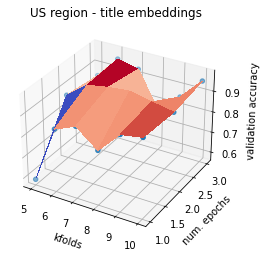

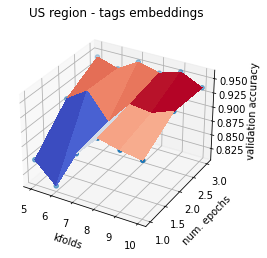

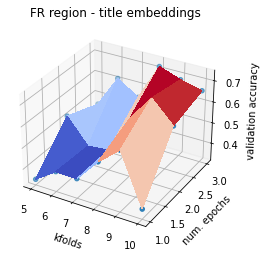

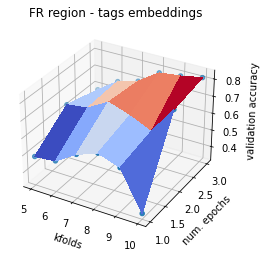

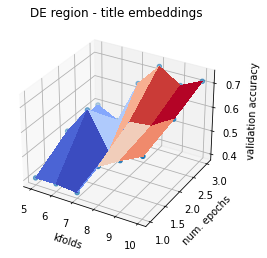

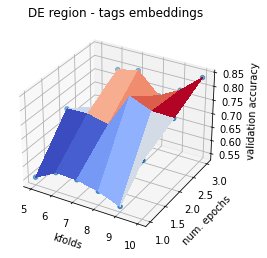

In [11]:
for region, _ in regions:
    for feat in features:
        # Filter history for region and feature
        df = history[history['region'] == region]
        df = df[df['feature'] == feat]
        
        # Create a 3d projection graph
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Do some math I don't fully understand to generate the data necessary for 3d surface contours
        Z = df.pivot_table(index='kfolds', columns='epochs', values='accuracy').T.values
        X_unique = np.sort(df['kfolds'].unique())
        Y_unique = np.sort(df['epochs'].unique())
        X, Y = np.meshgrid(X_unique, Y_unique)
    
        # Scatter plot the different points
        ax.scatter(df['kfolds'], df['epochs'], df['accuracy'])
        
        # Contour surface plot the space between the points
        ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        # set the all labels
        ax.set(xlabel='kfolds', ylabel='num. epochs', zlabel='validation accuracy', title='{} region - {} embeddings'.format(region, feat))
        
        # show the graph
        plt.show()

In [13]:
history['train time (s)'].sum() / 3600.

1.4269580818547143

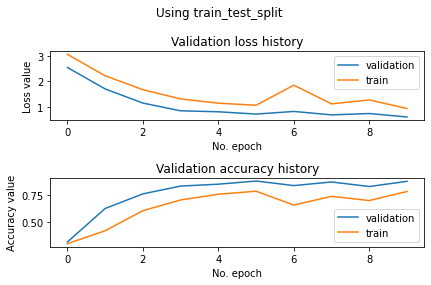

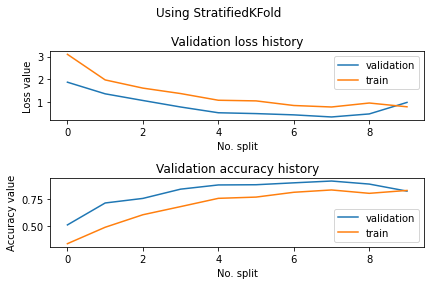

In [26]:
region_df, num_classes = load_region_data('US', 'english')        
X, Y = create_xy(region_df, 'tags')

def show_train_test_split():
    # Create, train, then save meta
    model = create_model(X, num_classes)

    loss_history, accuracy_history = [[],[]], [[],[]]
    to_categorical = tf.keras.utils.to_categorical

    # Kfold cross validation
    xtrain, xval, ytrain, yval = sk.model_selection.train_test_split(
        X, to_categorical(Y, num_classes=num_classes), shuffle=True
    )
    history = model.fit(
        xtrain, ytrain, validation_data=(xval, yval), verbose=0, epochs=10, batch_size=128
    )
    
    # Add values to training history
    loss_history[0].extend(history.history['val_loss'])
    loss_history[1].extend(history.history['loss'])
    accuracy_history[0].extend(history.history['val_categorical_accuracy'])
    accuracy_history[1].extend(history.history['categorical_accuracy'])

    plot_val_loss('Using train_test_split', loss_history, accuracy_history, xlabel='No. epoch')

def show_kfold():
    model = create_model(X, num_classes)

    loss_history, accuracy_history = [[],[]], [[],[]]
    to_categorical = tf.keras.utils.to_categorical
    
    skf = sk.model_selection.StratifiedKFold(n_splits=kfolds, shuffle=True)
    for train_index, val_index in skf.split(X, Y):
        # Get train and test fold
        xtrain, xval = X[train_index], X[val_index]
    
        # We need to convert the Y to a categorical type in order for the 
        # multi-classifier to train and validate properly
        ytrain = to_categorical(Y[train_index], num_classes=num_classes)
        yval = to_categorical(Y[val_index], num_classes=num_classes)
    
        # Train and validate
        history = model.fit(xtrain, ytrain, validation_data=(xval, yval), verbose=0,
                            epochs=1, batch_size=128)
    
        # Add values to training history
        loss_history[0].extend(history.history['val_loss'])
        loss_history[1].extend(history.history['loss'])
        accuracy_history[0].extend(history.history['val_categorical_accuracy'])
        accuracy_history[1].extend(history.history['categorical_accuracy'])

    plot_val_loss('Using StratifiedKFold', loss_history, accuracy_history)
    
show_train_test_split()
show_kfold()

In [28]:
history[history['region'] == 'US'].to_csv('history.csv')

In [33]:
history.groupby(['region'])['accuracy'].max()

region
DE    0.836519
FR    0.816667
US    0.971548
Name: accuracy, dtype: float64